### Installing necessary libraries

In [1]:
import findspark
findspark.init()

import matplotlib.pyplot as plt
import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import *
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score

### Initializing spark session

In [2]:
spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.sql.repl.eagerEval.enabled", "true") \
    .config("spark.driver.memory", "6g") \
    .config("spark.jars.packages", "databricks:spark-deep-learning:1.5.0-spark2.4-s_2.11") \
    .getOrCreate()
sc = spark.sparkContext
spark

Ivy Default Cache set to: /Users/neetesh/.ivy2/cache
The jars for the packages stored in: /Users/neetesh/.ivy2/jars
:: loading settings :: url = jar:file:/Users/neetesh/opt/anaconda3/envs/sparkdl/lib/python3.7/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
databricks#spark-deep-learning added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-a04da0ed-28aa-437a-9580-cf7a84d8d0f7;1.0
	confs: [default]
	found databricks#spark-deep-learning;1.5.0-spark2.4-s_2.11 in spark-packages
	found databricks#tensorframes;0.6.0-s_2.11 in spark-packages
	found org.apache.commons#commons-proxy;1.0 in central
	found org.apache.commons#commons-lang3;3.4 in local-m2-cache
	found com.typesafe.scala-logging#scala-logging-api_2.11;2.1.2 in central
	found com.typesafe.scala-logging#scala-logging-slf4j_2.11;2.1.2 in central
	found org.scala-lang#scala-reflect;2.11.0 in central
	found org.slf4j#slf4j-api;1.7.7 in central
	found org.tensorflo

2023-04-30 22:41:30 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### Downloading images

In [3]:
# !wget https://publiclyhosteddata.s3.amazonaws.com/nike-adidas-dataset.zip
# !unzip -o -q nike-adidas-dataset.zip

In [4]:
base_dir = 'nike-adidas-dataset'
train_dir = f'{base_dir}/train'
test_dir = f'{base_dir}/test'
partition_size = 100

class_names = ['adidas', 'nike']

def create_image_df(dir):
    adidas_df = spark.read.format("image").load(f"{dir}/{class_names[0]}").withColumn("label", lit(0))
    nike_df = spark.read.format("image").load(f"{dir}/{class_names[1]}").withColumn("label", lit(1))

    return adidas_df.unionAll(nike_df)

train_df = create_image_df(train_dir)
test_df = create_image_df(test_dir)

# Repartitioning data so because each partition would be loaded in memory individually.
train_df = train_df.repartition(partition_size)
test_df = test_df.repartition(partition_size)

### Displaying sample images

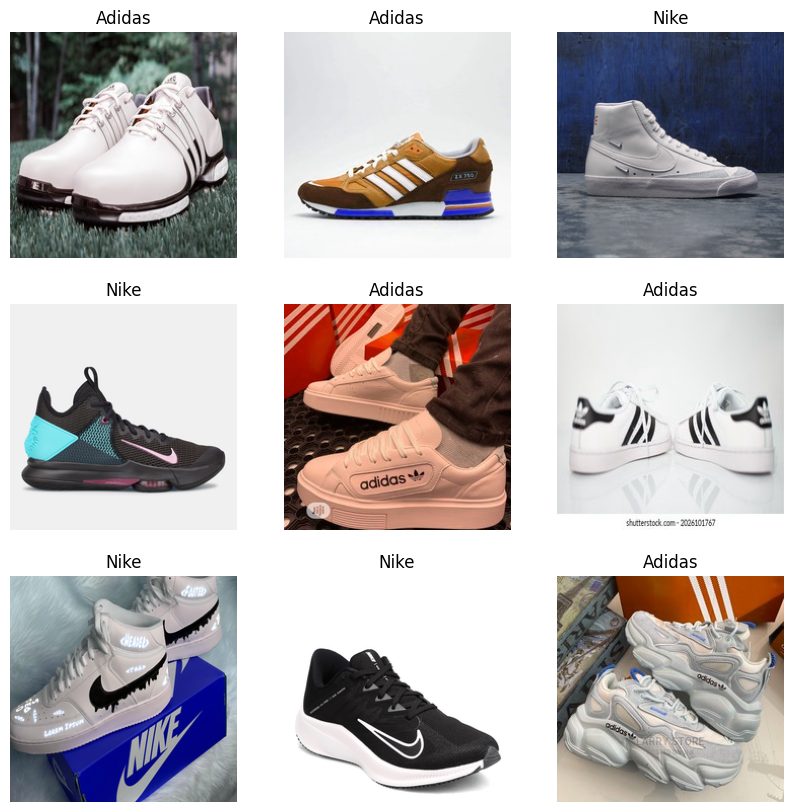

In [5]:
def display(dataframe, cmap=None):
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(dataframe.limit(9).collect()):
        ax = plt.subplot(3, 3, i + 1)
        data = img[0].data
        channels = img[0].nChannels
        height = img[0].height
        width = img[0].width
        array = np.frombuffer(data, dtype=np.uint8).reshape(height, width, channels)
        label = 'Adidas' if img.label == 0 else 'Nike'
        plt.imshow(array, cmap=cmap)
        plt.title(label)
        plt.axis("off")

    plt.show()

display(train_df)

### Model training

In [6]:
from sparkdl import DeepImageFeaturizer

pipeline = Pipeline(stages=[
    DeepImageFeaturizer(inputCol="image", outputCol="features", modelName="InceptionV3"),
    LogisticRegression(elasticNetParam=0.3, maxIter=10, regParam=0.05, labelCol="label")
])

# Fitting the model
model = pipeline.fit(train_df)

Using TensorFlow backend.
[Stage 5:>                                                        (0 + 8) / 100]2023-04-30 22:43:03.774738: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.2


2023-04-30 22:52:08 WARN  BLAS:61 - Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
2023-04-30 22:52:08 WARN  BLAS:61 - Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


### Model prediction

In [7]:
prediction_df = model.transform(test_df)
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
prediction_metrics_df = prediction_df.select("prediction", "label")
accuracy = evaluator.evaluate(prediction_metrics_df)
print(f"Accuracy on test data: {accuracy}")

[Stage 47:======================================================>(99 + 1) / 100]

Accuracy on test data: 0.9375


### Model Evaluation

In [8]:
prediction_metrics_data = prediction_metrics_df.collect()
preds = [item[0] for item in prediction_metrics_data]
labels = [item[1] for item in prediction_metrics_data]
pred_names = [class_names[int(item[0])] for item in prediction_metrics_data]
label_names = [class_names[int(item[1])] for item in prediction_metrics_data]

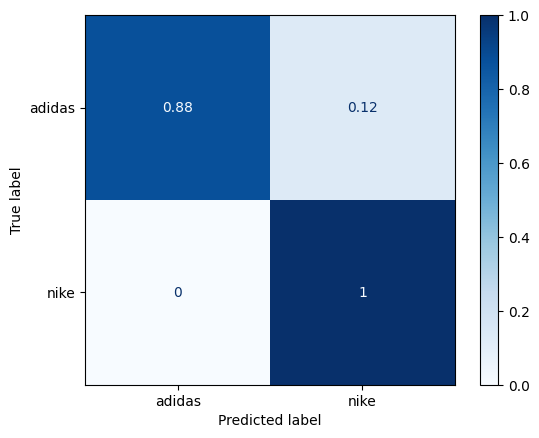

In [9]:
ConfusionMatrixDisplay.from_predictions(label_names, pred_names, labels=class_names, normalize='true', cmap=plt.cm.Blues)

####

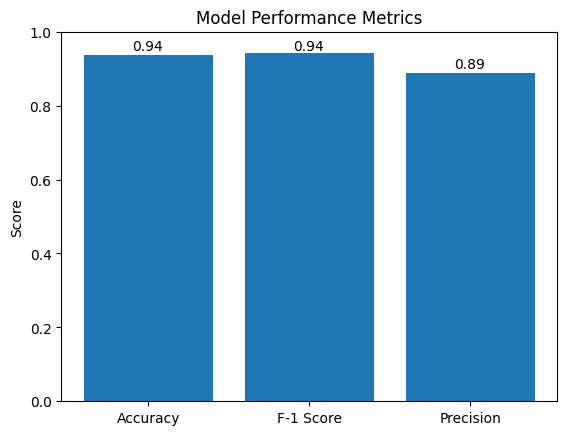

In [10]:
from sklearn.metrics import accuracy_score, f1_score, precision_score
import matplotlib.pyplot as plt

accuracy = accuracy_score(labels, preds)
f1_score = f1_score(labels, preds)
precision = precision_score(labels, preds)

# Create barplot
fig, ax = plt.subplots()
metrics = ['Accuracy', 'F-1 Score', 'Precision']
scores = [accuracy, f1_score, precision]
bars = ax.bar(metrics, scores)
ax.set_ylabel('Score')
ax.set_ylim(0, 1)
for bar in bars:
    yval = float("{:.2f}".format(bar.get_height()))
    plt.text(bar.get_x() + 0.3, yval + .01, yval)
ax.set_title('Model Performance Metrics')
plt.show()